### This script is used to check BP for DCM-RNN
- Keep the majority parameters "correct".
- Calculate the loss as a function of remaining parameter.
- Check whether BP can find the targeted optimal point.

In [455]:
import importlib
import numpy as np
import scipy as sp
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d
import math as mth
from tensorflow.python.framework import ops
from IPython.display import clear_output
from scipy.interpolate import interp1d
import os,shutil
import pandas as pd
from tensorflow.python.client import timeline

In [556]:
import CBI
import population
importlib.reload(CBI)
importlib.reload(population)

<module 'population' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/population.py'>

In [557]:
global_settings=type('container', (object,), {})()
global_settings.t_delta=0.25
global_settings.n_stimuli=1
global_settings.n_recurrent_step=12
global_settings.learning_rate=0.00001

###  Create a subject

In [580]:
flags=type('container', (object,), {})()
flags.random_hemodynamic_parameter = False
flags.random_h_state_initial = True
flags.random_x_state_initial = True

s=population.get_a_subject(flags=flags)
m=CBI.configure_a_scanner(t_delta=global_settings.t_delta,n_stimuli=global_settings.n_stimuli)
u,y,x,h=m.quick_scan(s,return_x=True,return_h=True)
parameter_true=s.show_all_variable_value(True)

Wxx


,From_r0,From_r1,From_r2
To_r0,0.75,0.00,0.00
To_r1,0.20,0.75,0.10
To_r2,0.10,0.20,0.75


Wxxu_s0


,From_r0,From_r1,From_r2
To_r0,0.0,0.0,0.0
To_r1,0.0,0.0,0.0
To_r2,0.0,0.0,-0.1


Wxu


,stimuli_0
To_r0,0.1
To_r1,0.0
To_r2,0.0


hemodynamic_parameters


,alpha,E0,k,gamma,tao,epsilon,V0,TE,r0,theta0
region_0,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25,40.3
region_1,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25,40.3
region_2,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25,40.3


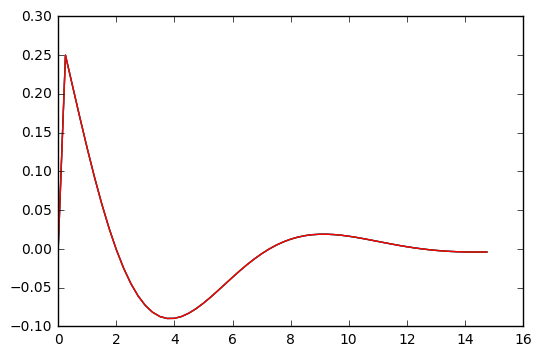

In [581]:
h_impulse_response = m.h_impulse_response(s)
plt.plot(np.arange(int(h_impulse_response.shape[-1]))*m.t_delta,h_impulse_response[:,0,:].transpose())

In [582]:
s.hemodynamic_parameters

,alpha,E0,k,gamma,tao,epsilon,V0,TE,r0,theta0
region_0,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25,40.3
region_1,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25,40.3
region_2,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25,40.3


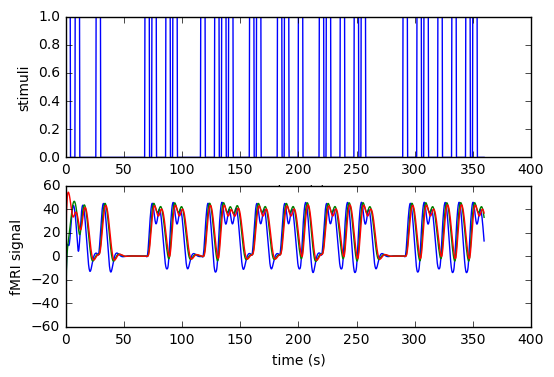

In [583]:
plt.subplot(211)
plt.plot(np.arange(m.n_time_point)*m.t_delta,u.transpose())
plt.xlabel('time (s)')
plt.ylabel('stimuli')
plt.subplot(212)
plt.plot(np.arange(m.n_time_point)*m.t_delta,y[:,0,:].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

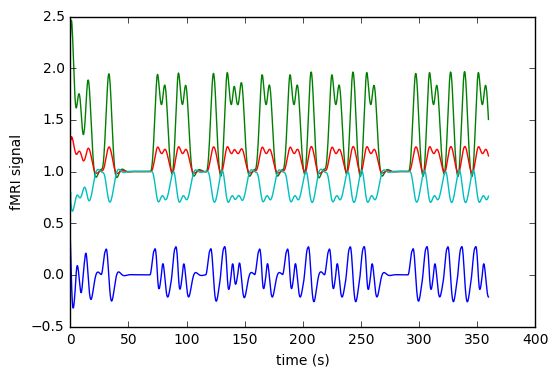

In [584]:
# plot it to check hemodynamic states to ensure they are in proper range
plt.plot(np.arange(m.n_time_point)*m.t_delta,h[2,:,:].transpose())
#plt.plot(np.arange(250,350),h[0,:,250:350].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

### Data preparation

In [585]:
import data_helper
importlib.reload(data_helper)

<module 'data_helper' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/data_helper.py'>

In [586]:
# target u: [m.n_stimuli, n_recurrent_step]
# target x: [m.n_region, n_recurrent_step]
n_recurrent_step=global_settings.n_recurrent_step

dh=data_helper.get_a_data_helper()
dh.u=u[:]
dh.x=x[:]
dh.y=y[:]

dh.u_list=dh.cut2shape(dh.u,[m.n_stimuli, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.x_list=dh.cut2shape(dh.x,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.y_list=dh.cut2shape(dh.y,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
print('u_list has '+str(len(dh.u_list))+' segments, each of size '+str(dh.u_list[0].shape))
print('x_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))
print('y_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))

u_list has 120 segments, each of size (1, 12)
x_list has 120 segments, each of size (3, 12)
y_list has 120 segments, each of size (3, 12)


### Build model

In [587]:
ops.reset_default_graph()
import DCM_RNN
importlib.reload(DCM_RNN)
dr=DCM_RNN.DCM_RNN(m,n_recurrent_step=global_settings.n_recurrent_step,learning_rate=global_settings.learning_rate)
# configure the model
dr.hyperparameter_values[dr.variable_scope_name_x]['sparse']=0.8
dr.hyperparameter_values[dr.variable_scope_name_h]['prior']=0.
dr.hyperparameter_values[dr.variable_scope_name_h]['gradient']=0.
util=DCM_RNN.utilities()

In [588]:
# build a model 
dr.build_a_model()
dr.parameter_profile

build_a_model: variables created.
build_a_model: layers created.
build_a_model: losses added.
build_a_model: finished.


{'rnn_cell_h/E0_r0:0': {'keyword': 'E0',
  'mask_gradient': 0.0,
  'mask_prior': 0.0,
  'mask_sparse': 0.0,
  'scope': 'rnn_cell_h',
  'shape': TensorShape([])},
 'rnn_cell_h/E0_r1:0': {'keyword': 'E0',
  'mask_gradient': 0.0,
  'mask_prior': 0.0,
  'mask_sparse': 0.0,
  'scope': 'rnn_cell_h',
  'shape': TensorShape([])},
 'rnn_cell_h/E0_r2:0': {'keyword': 'E0',
  'mask_gradient': 0.0,
  'mask_prior': 0.0,
  'mask_sparse': 0.0,
  'scope': 'rnn_cell_h',
  'shape': TensorShape([])},
 'rnn_cell_h/alpha_r0:0': {'keyword': 'alpha',
  'mask_gradient': 0.0,
  'mask_prior': 0.0,
  'mask_sparse': 0.0,
  'scope': 'rnn_cell_h',
  'shape': TensorShape([])},
 'rnn_cell_h/alpha_r1:0': {'keyword': 'alpha',
  'mask_gradient': 0.0,
  'mask_prior': 0.0,
  'mask_sparse': 0.0,
  'scope': 'rnn_cell_h',
  'shape': TensorShape([])},
 'rnn_cell_h/alpha_r2:0': {'keyword': 'alpha',
  'mask_gradient': 0.0,
  'mask_prior': 0.0,
  'mask_sparse': 0.0,
  'scope': 'rnn_cell_h',
  'shape': TensorShape([])},
 'rnn_cell

In [589]:
# training summary
acc_Wxx=1-util.rMSE(dr.Wxx,s.Wxx)
acc_Wxxu=[1-util.rMSE(dr.Wxxu[n],s.Wxxu[n]) for n in range(dr.n_stimuli)]
acc_Wxxu=tf.add_n(acc_Wxxu)
acc_Wxu=1-util.rMSE(dr.Wxu,s.Wxu.reshape((m.n_region,1)))

loss_summary = tf.scalar_summary('fMRI_prediction_loss',dr.loss_y)
acc_Wxx_summary = tf.scalar_summary('acc_Wxx',acc_Wxx)
acc_Wxxu_summary = tf.scalar_summary('acc_Wxxu',acc_Wxxu)
acc_Wxu_summary = tf.scalar_summary('acc_Wxu',acc_Wxu)
opt_summary = tf.merge_summary([loss_summary, acc_Wxx_summary, acc_Wxxu_summary,acc_Wxu_summary])

summary_dir = os.path.abspath(os.path.join(os.path.curdir, "summary"))

# remove existing files
for the_file in os.listdir(summary_dir):
    file_path = os.path.join(summary_dir, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [590]:
# open session and initilize
try:
    isess
except:
    isess = tf.InteractiveSession()
else:
    isess.close()
    isess = tf.InteractiveSession()

opt_init_all=tf.initialize_all_variables()
isess.run(opt_init_all)
# add summary
#summary_writer = tf.train.SummaryWriter(summary_dir, isess.graph)

### version 2, masks are written in the model

In [366]:
# test losses
# f=open('timeline.json', 'w')
loss_values_static=[]

current_value = 0.3
# set parameter value
Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
Wxu[0]=current_value*dr.t_delta
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

n_epoch=1
for epoch in range(n_epoch):
    loss_y_sum=0.
    loss_sparse_sum=0.
    loss_prior_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]

    #for i in range(0,len(dh.u_list)):
    for i in range(1):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.input_u]=dh.u_list[i]
        feed_dict[dr.input_y_true]=dh.y_list[i]
        #util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)

        grads_and_vars,processed_grads_and_vars,x_feed,h_feed,loss_y,loss_sparse_list,loss_sparse,loss_prior_list,loss_prior\
                                            = isess.run([
                                            dr.grads_and_vars,
                                            dr.processed_grads_and_vars,
                                            #dr.apply_gradient,
                                            dr.x_state_final,
                                            dr.h_state_final,
                                            dr.loss_y,
                                            dr.loss_sparse_list,
                                            dr.loss_sparse,
                                            dr.loss_prior_list,
                                            dr.loss_prior], feed_dict=feed_dict)
        print("segment {:g}, loss_y {:g}, loss_sparse {:g}, loss_prior {:g} "\
              .format(i, loss_y,loss_sparse, loss_prior))
        loss_y_sum+=loss_y 
        loss_sparse_sum+=loss_sparse
        loss_prior_sum+=loss_prior
    loss_values_static.append(loss_sparse_sum)
    print("epoch {:g}, loss_y {:g}, loss_sparse {:g}, loss_prior {:g} "\
              .format(epoch, loss_y_sum,loss_sparse_sum, loss_prior_sum))

segment 0, loss_y 0.0824449, loss_sparse 2.42, loss_prior 0 
epoch 0, loss_y 0.0824449, loss_sparse 2.42, loss_prior 0 


In [367]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
parameter_trained=util.show_all_variable_value(dr,isess,visFlag=False)
tmp=util.compare_parameters(parameter_trained,parameter_true,visFlag=True,parameter_list=['Wxx','Wxxu_s0','Wxu','hemodynamic_parameters'])

Wxx


set1                    set2                 difference          \
      From_r0 From_r1 From_r2 From_r0 From_r1 From_r2    From_r0 From_r1   
To_r0    0.75    0.00    0.00    0.75    0.00    0.00        0.0     0.0   
To_r1    0.20    0.75    0.10    0.20    0.75    0.10        0.0     0.0   
To_r2    0.10    0.20    0.75    0.10    0.20    0.75        0.0     0.0   

               
      From_r2  
To_r0     0.0  
To_r1     0.0  
To_r2     0.0

Wxxu_s0


set1                    set2                 difference          \
      From_r0 From_r1 From_r2 From_r0 From_r1 From_r2    From_r0 From_r1   
To_r0     0.0     0.0     0.0     0.0     0.0     0.0        0.0     0.0   
To_r1     0.0     0.0     0.0     0.0     0.0     0.0        0.0     0.0   
To_r2     0.0     0.0    -0.1     0.0     0.0    -0.1        0.0     0.0   

               
      From_r2  
To_r0     0.0  
To_r1     0.0  
To_r2     0.0

Wxu


,set1,set2,difference
,stimuli_0,stimuli_0,stimuli_0
To_r0,0.075,0.1,-0.025
To_r1,0.000,0.0,0.000
To_r2,0.000,0.0,0.000


hemodynamic_parameters


alpha        E0         k     gamma       tao  \
set1       region_0  0.320000  0.340000  0.650000  0.410000  0.980000   
           region_1  0.320000  0.340000  0.650000  0.410000  0.980000   
           region_2  0.320000  0.340000  0.650000  0.410000  0.980000   
set2       region_0  0.322472  0.311777  0.699581  0.393486  1.156395   
           region_1  0.348695  0.338680  0.603847  0.380131  0.997643   
           region_2  0.290763  0.319077  0.718197  0.397786  0.806494   
difference region_0 -0.002472  0.028223 -0.049582  0.016514 -0.176395   
           region_1 -0.028695  0.001320  0.046153  0.029869 -0.017643   
           region_2  0.029237  0.020923 -0.068197  0.012214  0.173506   

                          epsilon     V0            TE    r0        theta0  
set1       region_0  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_1  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_2  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
set2       region_0  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_1  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_2  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
difference region_0  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07  
           region_1  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07  
           region_2  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07

In [368]:
print(loss_y_sum)
print(loss_sparse_sum)
print(loss_prior_sum)

0.0824448987842
2.42000007629
0.0


In [491]:
s.h_state_initial

array([[ 0.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  1.]])

In [493]:
s.x_state.shape

(3, 1, 1440)

In [591]:
# set a particular initial point
Wxx=np.array([[-0.8,0.2,0],[0.9,-0.8,0.5],[0,0.7,-0.8]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.55]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.6*dr.t_delta 
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

In [596]:
# training
# f=open('timeline.json', 'w')
loss_y_values=[]
loss_sparse_values=[]
loss_prior_values=[]
loss_total_values=[]

parameter_tmp=isess.run(dr.Wxx)/dr.t_delta
parameter_initial1=float(parameter_tmp[1,0])
parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
parameter_initial2=float(parameter_tmp[1])
parameter_values1=[]
parameter_values2=[]
parameter_values1.append(parameter_initial1)
parameter_values2.append(parameter_initial2)
n_epoch=12
for epoch in range(n_epoch):
    loss_y_sum=0.
    loss_sparse_sum=0.
    loss_prior_sum=0.
    loss_total_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    #for i in range(0,len(dh.u_list)):
    # do not do BP for the first segments because of initial states uncertainty 
    
    for i in range(0,5):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.input_u]=dh.u_list[i]
        feed_dict[dr.input_y_true]=dh.y_list[i]
        #util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
   
        x_feed,h_feed,loss_y,loss_sparse,loss_prior,loss_total = isess.run([
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_prior,
                                                    dr.loss_total,], feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_prior_sum+=loss_prior
        loss_total_sum+=loss_total
        #print("segment {:g}, loss_y {:g}, loss_sparse {:g}, loss_prior {:g} "\
        #      .format(i, loss_y,loss_sparse, loss_prior))
    
    for i in range(5,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.input_u]=dh.u_list[i]
        feed_dict[dr.input_y_true]=dh.y_list[i]
        #util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
        #grads_and_vars_tmp
        grads_and_vars_tmp,tmp,x_feed,h_feed,loss_y,loss_sparse,loss_prior,loss_total, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([
                                                    dr.apply_gradient,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_prior,
                                                    dr.loss_total,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],
                                                    feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_prior_sum+=loss_prior
        loss_total_sum+=loss_total
        #print("segment {:g}, loss_y {:g}, loss_sparse {:g}, loss_prior {:g} "\
        #      .format(i, loss_y,loss_sparse, loss_prior))
        
    #print('epoch = '+str(epoch))
    parameter_tmp=isess.run(dr.Wxx)/dr.t_delta
    parameter_values1.append(float(parameter_tmp[1,0]))
    parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
    parameter_values2.append(float(parameter_tmp[1]))
    
    loss_y_values.append(loss_y_sum)
    loss_sparse_values.append(loss_sparse_sum)
    loss_prior_values.append(loss_prior_sum)
    loss_total_values.append(loss_total_sum)
    print("epoch {}, l_y {:g}, l_s {:g},l_p {:g}, l_t {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
         .format(epoch, loss_y_sum,loss_sparse_sum,float(loss_prior_sum),float(loss_total_sum), acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, l_y 2093.85, l_s 294.794,l_p 0, l_t 2388.64, acc_Wxx 0.949353, acc_Wxxu 0.86063, acc_Wxu 0.965878
epoch 1, l_y 2045.74, l_s 294.496,l_p 0, l_t 2340.24, acc_Wxx 0.94967, acc_Wxxu 0.869329, acc_Wxu 0.967141
epoch 2, l_y 2004.48, l_s 294.22,l_p 0, l_t 2298.7, acc_Wxx 0.949963, acc_Wxxu 0.878101, acc_Wxu 0.967802
epoch 3, l_y 1976.29, l_s 293.996,l_p 0, l_t 2270.28, acc_Wxx 0.950234, acc_Wxxu 0.88695, acc_Wxu 0.968473
epoch 4, l_y 1954.03, l_s 293.799,l_p 0, l_t 2247.83, acc_Wxx 0.95049, acc_Wxxu 0.895853, acc_Wxu 0.969147
epoch 5, l_y 1935.81, l_s 293.622,l_p 0, l_t 2229.43, acc_Wxx 0.950734, acc_Wxxu 0.904793, acc_Wxu 0.969813


KeyboardInterrupt: 

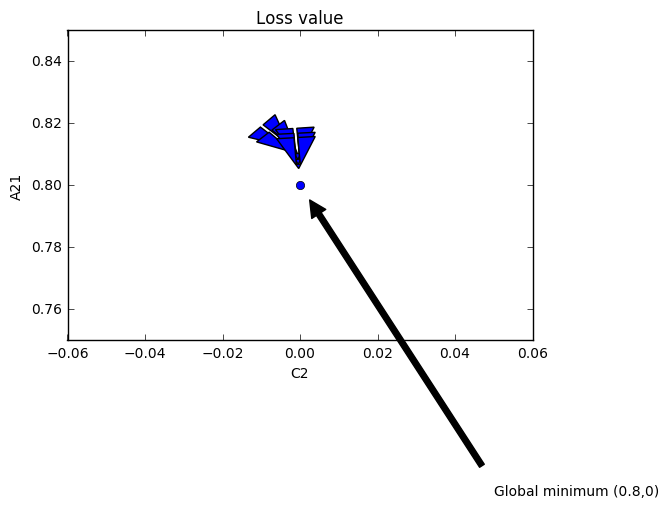

In [597]:
# plot the BP process
ax = plt.axes()
# plt.figure()
for idx in range(1,len(loss_total_values)):
    ax.arrow(float(parameter_values2[idx-1]), parameter_values1[idx-1],\
             float(parameter_values2[idx])-float(parameter_values2[idx-1]), (parameter_values1[idx]-parameter_values1[idx-1]),\
            head_width=0.01, head_length=0.01,length_includes_head=True)


plt.annotate('Global minimum (0.8,0)', xy=(0, 0.8), xytext=(0.05, 0.7),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot(0,0.8,'bo')
plt.title('Loss value')
plt.xlabel('C2')
plt.ylabel('A21')
plt.show()



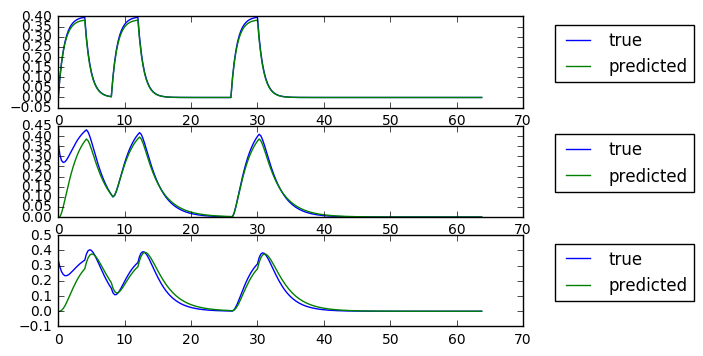

In [598]:
# visulize pridicted x_state and true x_state (after training)
x_predicted=util.forward_pass_x(dr,dh,isess)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [ ]:
# visulize pridicted h_state and true h_state (before training)
h_predicted=util.forward_pass_h(dr,dh,isess)
n_monitor=256
i_h_state=1
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,h[n,i_h_state,0:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,h_predicted[n][i_h_state,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

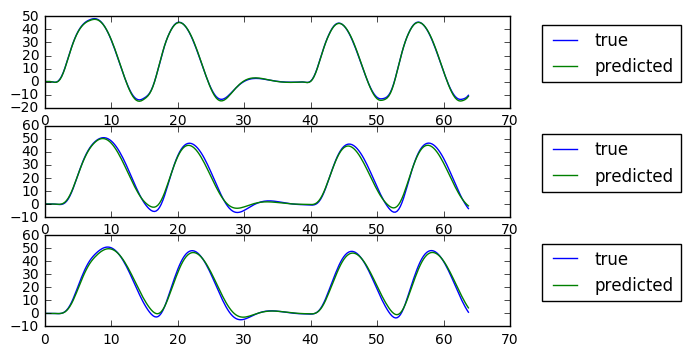

In [489]:
y_predicted=util.forward_pass_y(dr,dh,isess)
n_monitor=256#m.n_time_point
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [490]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
parameter_trained=util.show_all_variable_value(dr,isess,visFlag=False)
tmp=util.compare_parameters(parameter_trained,parameter_true,visFlag=True,parameter_list=['Wxx','Wxxu_s0','Wxu','hemodynamic_parameters'])

Wxx


set1                        set2                 difference  \
        From_r0   From_r1   From_r2 From_r0 From_r1 From_r2    From_r0   
To_r0  0.744434  0.005789 -0.000004    0.75    0.00    0.00  -0.005566   
To_r1  0.164515  0.733437  0.081715    0.20    0.75    0.10  -0.035485   
To_r2  0.079357  0.209877  0.793387    0.10    0.20    0.75  -0.020643   

                           
        From_r1   From_r2  
To_r0  0.005789 -0.000004  
To_r1 -0.016563 -0.018285  
To_r2  0.009877  0.043387

Wxxu_s0


set1                        set2                 difference  \
        From_r0   From_r1   From_r2 From_r0 From_r1 From_r2    From_r0   
To_r0  0.000004  0.000004 -0.000004     0.0     0.0     0.0   0.000004   
To_r1 -0.000038  0.000008  0.000001     0.0     0.0     0.0  -0.000038   
To_r2  0.000001 -0.000002 -0.091910     0.0     0.0    -0.1   0.000001   

                           
        From_r1   From_r2  
To_r0  0.000004 -0.000004  
To_r1  0.000008  0.000001  
To_r2 -0.000002  0.008090

Wxu


,set1,set2,difference
,stimuli_0,stimuli_0,stimuli_0
To_r0,0.109019,0.1,0.009019
To_r1,-0.005727,0.0,-0.005727
To_r2,-0.000068,0.0,-0.000068


hemodynamic_parameters


alpha        E0         k     gamma       tao  \
set1       region_0  0.320728  0.323513  0.646672  0.410640  0.929176   
           region_1  0.296247  0.375357  0.647624  0.408036  0.960233   
           region_2  0.299447  0.351756  0.640440  0.410429  0.894106   
set2       region_0  0.312815  0.332341  0.661574  0.405569  0.903315   
           region_1  0.333587  0.352575  0.599501  0.399961  1.058190   
           region_2  0.307655  0.360478  0.631345  0.412528  0.900510   
difference region_0  0.007913 -0.008829 -0.014902  0.005072  0.025861   
           region_1 -0.037340  0.022782  0.048123  0.008074 -0.097956   
           region_2 -0.008207 -0.008722  0.009094 -0.002099 -0.006403   

                          epsilon     V0            TE    r0        theta0  
set1       region_0  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_1  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_2  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
set2       region_0  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_1  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
           region_2  4.000000e-01  100.0  3.000000e-02  25.0  4.030000e+01  
difference region_0  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07  
           region_1  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07  
           region_2  5.960464e-09    0.0 -6.705523e-10   0.0 -7.629395e-07

In [121]:
np.sqrt(0.0015)

0.038729833462074169